In [73]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import STL
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_regression
# from sklearn.preprocessing import PolynomialFeatures

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# Load actual data from the Excel file
actual_data = pd.read_excel("../DATAFORMODELtrain200824.xlsx")

# Convert 'Date' to datetime format
actual_data['Date'] = pd.to_datetime(actual_data['Date'], format='%m/%d/%Y %H:%M')



In [5]:
# Filter the actual data to the specified date range
start_date = "2024-07-01 23:00"
end_date = "2024-08-20 23:00"
actual_data_filtered = actual_data[(actual_data['Date'] >= start_date) & (actual_data['Date'] <= end_date)]

# Load forecast data from the CSV file
forecast_data = pd.read_csv("../forecast_output.csv")

# Convert 'ds' to datetime format
forecast_data['ds'] = pd.to_datetime(forecast_data['ds'])

# Filter the forecast data to the specified date range
forecast_data_filtered = forecast_data[(forecast_data['ds'] >= start_date) & (forecast_data['ds'] <= end_date)]


In [6]:
# Merge actual and forecasted data on the date column
merged_data = pd.merge(actual_data_filtered[['Date', 'PriceSK']],
                       forecast_data_filtered[['ds', 'yhat']],
                       left_on='Date',
                       right_on='ds',
                       how='inner')

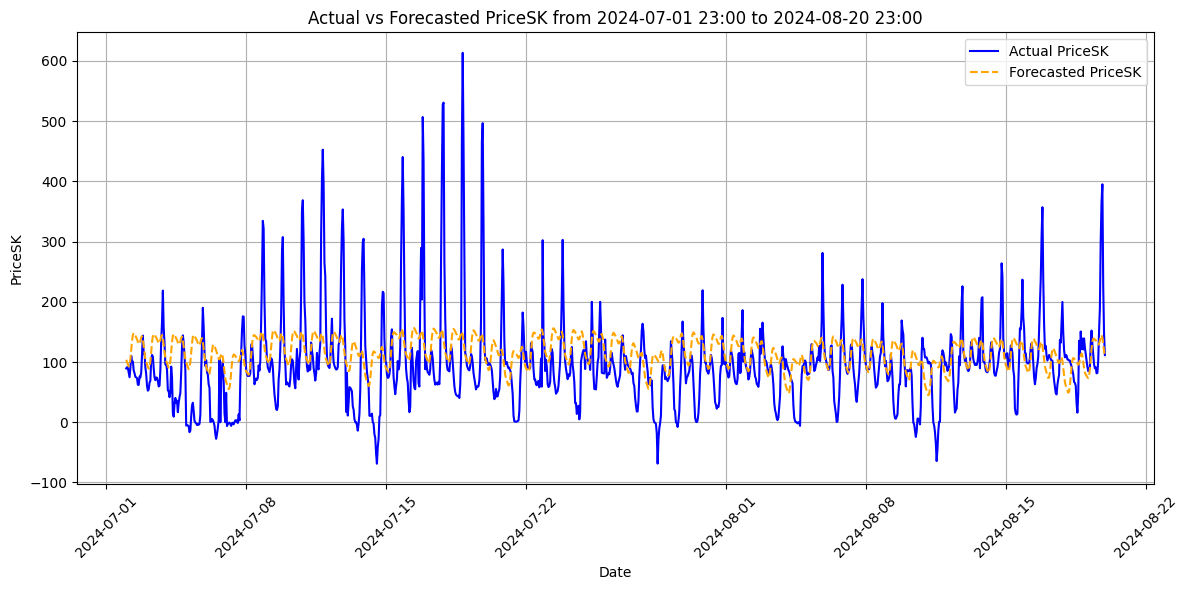

In [7]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['PriceSK'], label='Actual PriceSK', color='blue')
plt.plot(merged_data['Date'], merged_data['yhat'], label='Forecasted PriceSK', color='orange', linestyle='--')
plt.xlabel('Date')
plt.ylabel('PriceSK')
plt.title('Actual vs Forecasted PriceSK from 2024-07-01 23:00 to 2024-08-20 23:00')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering

In [37]:
data = actual_data.copy()

In [38]:
columns_to_drop = [
    'Y', 'M', 'Day', 'H', 'Y2016',	'Y2017',	'Y2018',	'Y2019',	'Y2020',	'Y2021',	'Y2022',	'Y2023',	'Y2024',
    'M1',	'M2',	'M3',	'M4',	'M5',	'M6',	'M7',	'M8',	'M9',	'M10',	'M11',	'M12',
    'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10',
    'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
    'h20', 'h21', 'h22', 'h23', 'h24',
    'PriceCZ', 'PriceHU', 'PriceRO'
]

In [39]:
data = data.drop(columns=columns_to_drop)

In [40]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Get the correlations of all columns with 'PriceSK'
price_sk_correlation = correlation_matrix['PriceSK'].sort_values(ascending=False)

# Display the most relevant features that correlate with 'PriceSK'
print(price_sk_correlation)

PriceSK         1.000000
GAS             0.885140
COAL            0.810247
CO2             0.612290
UNAVHYDRBG      0.565112
T2MALLPCO2      0.545252
UNAVGASBG       0.528106
UNAVHYDRALL     0.489056
UNAVGASALL      0.458272
Date            0.452247
UNAVGASSK       0.442859
UNAVTPPHU       0.429091
UNAVGASHU       0.417407
UNAVNUCFR       0.405772
UNAVTPPSK       0.371019
SOLMAX          0.290895
UA_SK           0.239188
UNAVLIGNHU      0.224148
UNAVHYDRRO      0.179999
PL_SK           0.169328
UNAVTPPBG       0.163033
PMIHU           0.139165
WDAY            0.123028
UNAVHYDRFR      0.122945
HUSOLGEN        0.115321
UNAVGASCZ       0.108427
UNAVNUCHU       0.093346
T2MALLNONLIN    0.076990
RHSOLGEN        0.071225
T2MROPSQ        0.066608
T2MHUPSQ        0.066037
T2MROP          0.060558
T2MRO           0.060558
UADEM           0.056461
T2MSKPSQ        0.055825
T2MALLP         0.054306
T2MALL          0.054306
T2MHUP          0.053502
T2MHU           0.053502
T2MALLMIN       0.053386


In [41]:
# Handling Missing Values
data = data.interpolate(method='linear')  # Example of linear interpolation

# Feature Engineering
data['hour'] = data['Date'].dt.hour
data['day_of_week'] = data['Date'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
data['month'] = data['Date'].dt.month
data['rolling_mean_7d'] = data['PriceSK'].rolling(window=7).mean()  # Example of rolling mean
data['lag_1'] = data['PriceSK'].shift(1)  # Example of lag feature

In [42]:
# Mutual Information for Feature Selection
X = data.drop(['PriceSK', 'Date'], axis=1)
y = data['PriceSK']

# Ensure all columns are numeric or properly formatted for mutual_info_regression
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

mi = mutual_info_regression(X, y)
mi_scores = pd.Series(mi, name="MI Scores", index=X.columns).sort_values(ascending=False)


In [43]:
print(mi_scores)

lag_1              1.920385
rolling_mean_7d    1.261757
GAS                0.990095
COAL               0.982151
UNAVGASRO          0.913351
CO2                0.863419
PMIHU              0.857164
COALTOGAS          0.833687
UNAVGASHU          0.797541
UNAVTPPRO          0.746934
UNAVGASALL         0.727710
UNAVTPPBG          0.720666
UNAVLIGNRO         0.709173
UNAVTPPHU          0.693779
UNAVHYDRALL        0.673793
SOLMAX             0.601289
UNAVLIGNBG         0.580840
UNAVHYDRBG         0.571434
UNAVNUCFR          0.535747
UA_HU              0.531698
UNAVTPPCZ          0.509616
UNAVNUCALL         0.505493
UA_EU              0.503606
UNAVLIGNALL        0.495926
UNAVLIGNCZ         0.489345
UNAVTPPSL          0.474731
UNAVLIGNSL         0.471686
T2MALLMAX          0.463632
T2MALLMIN          0.460164
UNAVHYDRFR         0.458166
T2MALLPCO2         0.453372
UNAVGASCZ          0.448348
RORDE_HP           0.445723
UNAVLIGNHU         0.428814
UNAVTPPALL         0.423502
PL_SK              0

# New Feature Engineering

In [44]:
# Retain top N features based on MI scores
top_features = mi_scores[mi_scores > 0.5].index  # For example, keep features with MI score > 0.5
X_filtered = X[top_features]

In [45]:
lasso = LassoCV(cv=10)
lasso.fit(X_filtered, y)

# Get the coefficients of the features
lasso_coefficients = pd.Series(lasso.coef_, index=X_filtered.columns).sort_values(ascending=False)

# Filter features based on non-zero coefficients
selected_features = lasso_coefficients[lasso_coefficients != 0].index
X_selected = X_filtered[selected_features]
print("Selected Features based on Lasso:", selected_features)

Selected Features based on Lasso: Index(['lag_1', 'UNAVHYDRBG', 'UNAVTPPHU', 'UNAVGASALL', 'UNAVHYDRALL',
       'UNAVNUCFR', 'SOLMAX', 'UNAVTPPCZ', 'UNAVLIGNRO', 'UNAVLIGNBG'],
      dtype='object')


In [46]:
# Initialize the model
rf = RandomForestRegressor()
rfe = RFE(estimator=rf, n_features_to_select=10)  # Adjust the number of features to keep
rfe.fit(X_filtered, y)

# Get the ranking of features
feature_ranking = pd.Series(rfe.ranking_, index=X_filtered.columns).sort_values()
selected_rfe_features = feature_ranking[feature_ranking == 1].index
print("Selected Features based on RFE:", selected_rfe_features)

Selected Features based on RFE: Index(['lag_1', 'UNAVTPPCZ', 'UNAVNUCFR', 'SOLMAX', 'UNAVGASALL', 'COALTOGAS',
       'UA_EU', 'CO2', 'GAS', 'rolling_mean_7d'],
      dtype='object')


In [47]:
# Calculate the correlation matrix
corr_matrix = X_filtered.corr()

# Identify highly correlated features
correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:  # Set your threshold here
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)

# Drop highly correlated features
X_uncorrelated = X_filtered.drop(columns=correlated_features)
print("Uncorrelated Features:", X_uncorrelated.columns)

Uncorrelated Features: Index(['lag_1', 'UNAVGASRO', 'CO2', 'PMIHU', 'COALTOGAS', 'UNAVGASHU',
       'UNAVTPPRO', 'UNAVGASALL', 'UNAVTPPBG', 'UNAVHYDRALL', 'SOLMAX',
       'UNAVNUCFR', 'UA_HU', 'UNAVTPPCZ', 'UNAVNUCALL'],
      dtype='object')


In [48]:
# Lagged Features
data['lag_2'] = data['PriceSK'].shift(2)
data['lag_3'] = data['PriceSK'].shift(3)
data['lag_6'] = data['PriceSK'].shift(6)
data['lag_12'] = data['PriceSK'].shift(12)
data['lag_24'] = data['PriceSK'].shift(24)

In [49]:
# Rolling Statistics
data['rolling_mean_3h'] = data['PriceSK'].rolling(window=3).mean()
data['rolling_mean_12h'] = data['PriceSK'].rolling(window=12).mean()
data['rolling_mean_24h'] = data['PriceSK'].rolling(window=24).mean()

data['rolling_std_3h'] = data['PriceSK'].rolling(window=3).std()
data['rolling_std_12h'] = data['PriceSK'].rolling(window=12).std()
data['rolling_std_24h'] = data['PriceSK'].rolling(window=24).std()

data['ewm_12h'] = data['PriceSK'].ewm(span=12).mean()  # Exponentially weighted moving average with span of 12 hours
data['ewm_24h'] = data['PriceSK'].ewm(span=24).mean()  # Exponentially weighted moving average with span of 24 hours

In [50]:
# Fourier Transform (FFT) Features
fft_vals = fft(data['PriceSK'].fillna(0).values)

# Adding FFT features (real and imaginary parts)
data['fft_real'] = np.real(fft_vals)
data['fft_imag'] = np.imag(fft_vals)

# Optional: Adding the magnitude of the FFT values to capture the strength of frequency components
data['fft_magnitude'] = np.abs(fft_vals)

In [72]:
# Calculate the correlation matrix
corr_matrix = X_filtered.corr()

# Identify moderately correlated features (0.3 < |correlation| < 0.8)
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
potential_interactions = corr_pairs[(corr_pairs > 0.3) & (corr_pairs < 0.8)]
print("Potential Feature Interactions based on Correlation:\n", potential_interactions)

Potential Feature Interactions based on Correlation:
 UNAVGASHU        UNAVGASALL         0.793453
UNAVTPPRO        UNAVGASRO          0.778379
CO2              UNAVHYDRBG         0.752262
UNAVGASALL       UNAVTPPHU          0.751905
UNAVTPPRO        CO2                0.735473
UNAVLIGNRO       CO2                0.731462
UA_HU            SOLMAX             0.713815
CO2              SOLMAX             0.689153
UA_HU            CO2                0.686976
SOLMAX           UA_EU              0.664962
COAL             CO2                0.658329
UNAVHYDRALL      CO2                0.656943
UA_HU            UNAVHYDRBG         0.649506
SOLMAX           UNAVHYDRBG         0.641711
COALTOGAS        GAS                0.632921
GAS              CO2                0.624292
CO2              rolling_mean_7d    0.622237
COALTOGAS        CO2                0.606463
lag_1            CO2                0.605664
UNAVHYDRBG       GAS                0.592894
UA_HU            UNAVTPPRO          0.592181
U

In [78]:
# Select only numeric columns for spline interpolation
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Perform spline interpolation on numeric columns
data[numeric_columns] = data[numeric_columns].interpolate(method='spline', order=3)

# Verify that there are no NaN values left in numeric columns
print("Number of NaN values after spline interpolation:\n", data[numeric_columns].isna().sum())

Number of NaN values after spline interpolation:
 PriceSK                   0
PMIHU                     0
GAS                       0
COAL                      0
CO2                       0
COALTOGAS                 0
WDAY                      0
DOFFHU                    0
DOFFSK                    0
DOFFRO                    0
WND                       0
T2MALL                    0
T2MALLMAX                 0
T2MALLMIN                 0
T2MALLAV                  0
T2MALLNONLIN              0
T2MALLP                   0
T2MALLPCO2                0
T2MALLPROR                0
T2MHUNORM                 0
THUDEVNORM                0
T2MHUPSQ                  0
T2MHUP                    0
T2MHU                     0
PRECHU                    0
WS10MHU                   0
ALLSKY1HU                 0
T2MSKPSQ                  0
T2MSKP                    0
T2MSK                     0
PRECSK                    0
WS10MSK                   0
ALLSKY1SK                 0
T2MROPSQ                  

In [83]:
# Forward fill remaining NaN values
data = data.ffill()

# Alternatively, use backward fill if it makes more sense for your data
# data = data.fillna(method='bfill')

In [85]:
# Drop rows with any remaining NaN values
data = data.dropna()

# Check if all NaN values are handled
print("Number of NaN values after dropping:\n", data.isna().sum())

Number of NaN values after dropping:
 Date                     0
PriceSK                  0
PMIHU                    0
GAS                      0
COAL                     0
CO2                      0
COALTOGAS                0
WDAY                     0
DOFFHU                   0
DOFFSK                   0
DOFFRO                   0
WND                      0
T2MALL                   0
T2MALLMAX                0
T2MALLMIN                0
T2MALLAV                 0
T2MALLNONLIN             0
T2MALLP                  0
T2MALLPCO2               0
T2MALLPROR               0
T2MHUNORM                0
THUDEVNORM               0
T2MHUPSQ                 0
T2MHUP                   0
T2MHU                    0
PRECHU                   0
WS10MHU                  0
ALLSKY1HU                0
T2MSKPSQ                 0
T2MSKP                   0
T2MSK                    0
PRECSK                   0
WS10MSK                  0
ALLSKY1SK                0
T2MROPSQ                 0
T2MROP           

In [86]:
# Define the feature pairs to interact based on the correlations and domain knowledge
selected_pairs = [
    ('GAS', 'CO2'),
    ('COAL', 'CO2'),
    ('COALTOGAS', 'GAS'),
    ('lag_1', 'CO2'),
    ('rolling_mean_7d', 'CO2'),
    ('UNAVTPPRO', 'CO2'),
    ('SOLMAX', 'CO2'),
    ('UNAVHYDRALL', 'CO2'),
    ('UA_HU', 'SOLMAX'),
    ('UNAVTPPCZ', 'CO2')
]

In [87]:
# Creating interaction terms
for (feature1, feature2) in selected_pairs:
    interaction_name = f"{feature1}_x_{feature2}"
    data[interaction_name] = data[feature1] * data[feature2]

In [88]:
# Creating polynomial terms for selected features
polynomial_features = ['GAS', 'COAL', 'CO2', 'SOLMAX', 'lag_1', 'rolling_mean_7d']

# Generate polynomial features up to degree 2
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_features = poly.fit_transform(data[polynomial_features])

# Create a DataFrame for polynomial features
poly_feature_names = poly.get_feature_names_out(polynomial_features)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names)

# Add these polynomial features back to the main DataFrame
data = pd.concat([data, poly_df], axis=1)

print("Created Interaction and Polynomial Features:\n", data.head())

Created Interaction and Polynomial Features:
                   Date  PriceSK  PMIHU   GAS   COAL   CO2  COALTOGAS  WDAY  \
24 2016-01-02 00:00:00     0.01   49.1  15.3  47.75  7.45   3.120915   0.0   
25 2016-01-02 01:00:00     1.00   49.1  15.3  47.75  7.45   3.120915   0.0   
26 2016-01-02 02:00:00     0.01   49.1  15.3  47.75  7.45   3.120915   0.0   
27 2016-01-02 03:00:00     0.01   49.1  15.3  47.75  7.45   3.120915   0.0   
28 2016-01-02 04:00:00     2.01   49.1  15.3  47.75  7.45   3.120915   0.0   

    DOFFHU  DOFFSK  DOFFRO  WND    T2MALL  T2MALLMAX  T2MALLMIN  T2MALLAV  \
24     0.0     0.0     1.0  1.0 -5.793333  -3.203333  -7.416667 -4.303194   
25     0.0     0.0     1.0  1.0 -6.040000  -3.203333  -7.416667 -4.325556   
26     0.0     0.0     1.0  1.0 -6.220000  -3.203333  -7.416667 -4.352222   
27     0.0     0.0     1.0  1.0 -6.263333  -3.203333  -7.416667 -4.372222   
28     0.0     0.0     1.0  1.0 -6.340000  -3.203333  -7.416667 -4.385833   

    T2MALLNONLIN   T2M

In [91]:
# Combining results from different feature selection methods
selected_features_lasso = set(selected_features)
selected_features_rfe = set(selected_rfe_features)
selected_features_mi = set(top_features)

# Find common features across multiple selection methods
final_selected_features = selected_features_lasso.intersection(selected_features_rfe, selected_features_mi)

print("Final Selected Features from Multiple Methods:", final_selected_features)

Final Selected Features from Multiple Methods: {'SOLMAX', 'UNAVGASALL', 'lag_1', 'UNAVNUCFR', 'UNAVTPPCZ'}


In [95]:
# Convert the set of final selected features to a list
final_selected_features = list(final_selected_features)

# Calculate the correlation matrix for the final selected features
corr_matrix_final = data[final_selected_features].corr().abs()

# Identify highly correlated features
upper = corr_matrix_final.where(np.triu(np.ones(corr_matrix_final.shape), k=1).astype(bool))
highly_correlated = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features
final_uncorrelated_features = list(set(final_selected_features).difference(set(highly_correlated)))
print("Final Uncorrelated Features for Prophet:", final_uncorrelated_features)

Final Uncorrelated Features for Prophet: ['UNAVTPPCZ', 'UNAVGASALL', 'UNAVNUCFR']


In [98]:
# Define the target and feature set, excluding the target variable 'PriceSK'
X_poly = data[poly_feature_names]  # This should be your polynomial features DataFrame
y = data['PriceSK']  # Target variable

In [99]:
# Check and handle any remaining NaN values
X_poly = X_poly.ffill().bfill().dropna()
y = y.ffill().bfill().dropna()

# Verify that there are no remaining NaN values
print("Number of NaN values in X_poly:", X_poly.isna().sum().sum())
print("Number of NaN values in y:", y.isna().sum().sum())

Number of NaN values in X_poly: 0
Number of NaN values in y: 0


In [100]:
# Fit LassoCV model
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X_poly, y)

# Get selected polynomial features from Lasso
selected_poly_features = X_poly.columns[(lasso.coef_ != 0)]
print("Selected Polynomial Features from LASSO:", selected_poly_features)

Selected Polynomial Features from LASSO: Index(['GAS SOLMAX', 'COAL SOLMAX', 'CO2 SOLMAX', 'SOLMAX^2', 'SOLMAX lag_1',
       'lag_1^2', 'rolling_mean_7d^2'],
      dtype='object')


In [101]:
# Calculate the correlation matrix for the selected polynomial features
corr_matrix_poly = data[selected_poly_features].corr().abs()

# Identify highly correlated features (correlation > 0.9)
upper_tri = corr_matrix_poly.where(np.triu(np.ones(corr_matrix_poly.shape), k=1).astype(bool))
highly_correlated_poly = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

# Drop highly correlated polynomial features
final_poly_features = set(selected_poly_features).difference(set(highly_correlated_poly))
print("Final Selected Polynomial Features:", final_poly_features)

Final Selected Polynomial Features: {'GAS SOLMAX', 'CO2 SOLMAX', 'SOLMAX lag_1', 'lag_1^2'}


In [102]:
# Assuming you have your original final selected features in 'final_uncorrelated_features'
combined_features = list(final_poly_features) + list(final_uncorrelated_features)

print("Combined Features for Prophet:", combined_features)

Combined Features for Prophet: ['GAS SOLMAX', 'CO2 SOLMAX', 'SOLMAX lag_1', 'lag_1^2', 'UNAVTPPCZ', 'UNAVGASALL', 'UNAVNUCFR']


# Previous Feature Engineering

In [15]:
# Interaction Features
data['PriceCZ_GAS'] = data['PriceCZ'] * data['GAS']
data['COAL_CO2'] = data['COAL'] * data['CO2']

In [16]:
# Polynomial Features for Selected Variables
poly = PolynomialFeatures(degree=2, include_bias=False)
selected_features = ['GAS', 'COAL', 'CO2', 'PriceCZ', 'PriceHU']
poly_features = poly.fit_transform(data[selected_features])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(selected_features))


In [17]:
# Merge Polynomial Features back to the DataFrame
data = pd.concat([data, poly_df], axis=1)

In [18]:
# Dimensionality Reduction using PCA for Less Significant Features
less_significant_features = ['UNAVTPPRO', 'UNAVGASALL', 'UNAVTPPBG', 'UNAVLIGNRO']
pca = PCA(n_components=2)
pca_features = pca.fit_transform(data[less_significant_features])
pca_df = pd.DataFrame(pca_features, columns=[f'PCA_{i+1}' for i in range(2)])
data = pd.concat([data, pca_df], axis=1)

In [19]:
# Feature Selection using LASSO
X = data.drop(['PriceSK', 'Date'], axis=1).fillna(0)
y = data['PriceSK']
lasso = LassoCV(cv=10, random_state=42)
lasso.fit(X, y)

LassoCV(cv=10, random_state=42)

In [20]:
# Get selected features from LASSO
selected_features = X.columns[(lasso.coef_ != 0)]
print("Selected Features from LASSO:", selected_features)

Selected Features from LASSO: Index(['T2MALLPROR', 'UNAVNUCFR', 'DEWINDGEN', 'COAL_CO2', 'GAS PriceCZ',
       'COAL^2', 'COAL CO2', 'COAL PriceHU', 'CO2 PriceCZ', 'CO2 PriceHU',
       'PriceCZ^2', 'PriceHU^2'],
      dtype='object')


# Ploting New Features

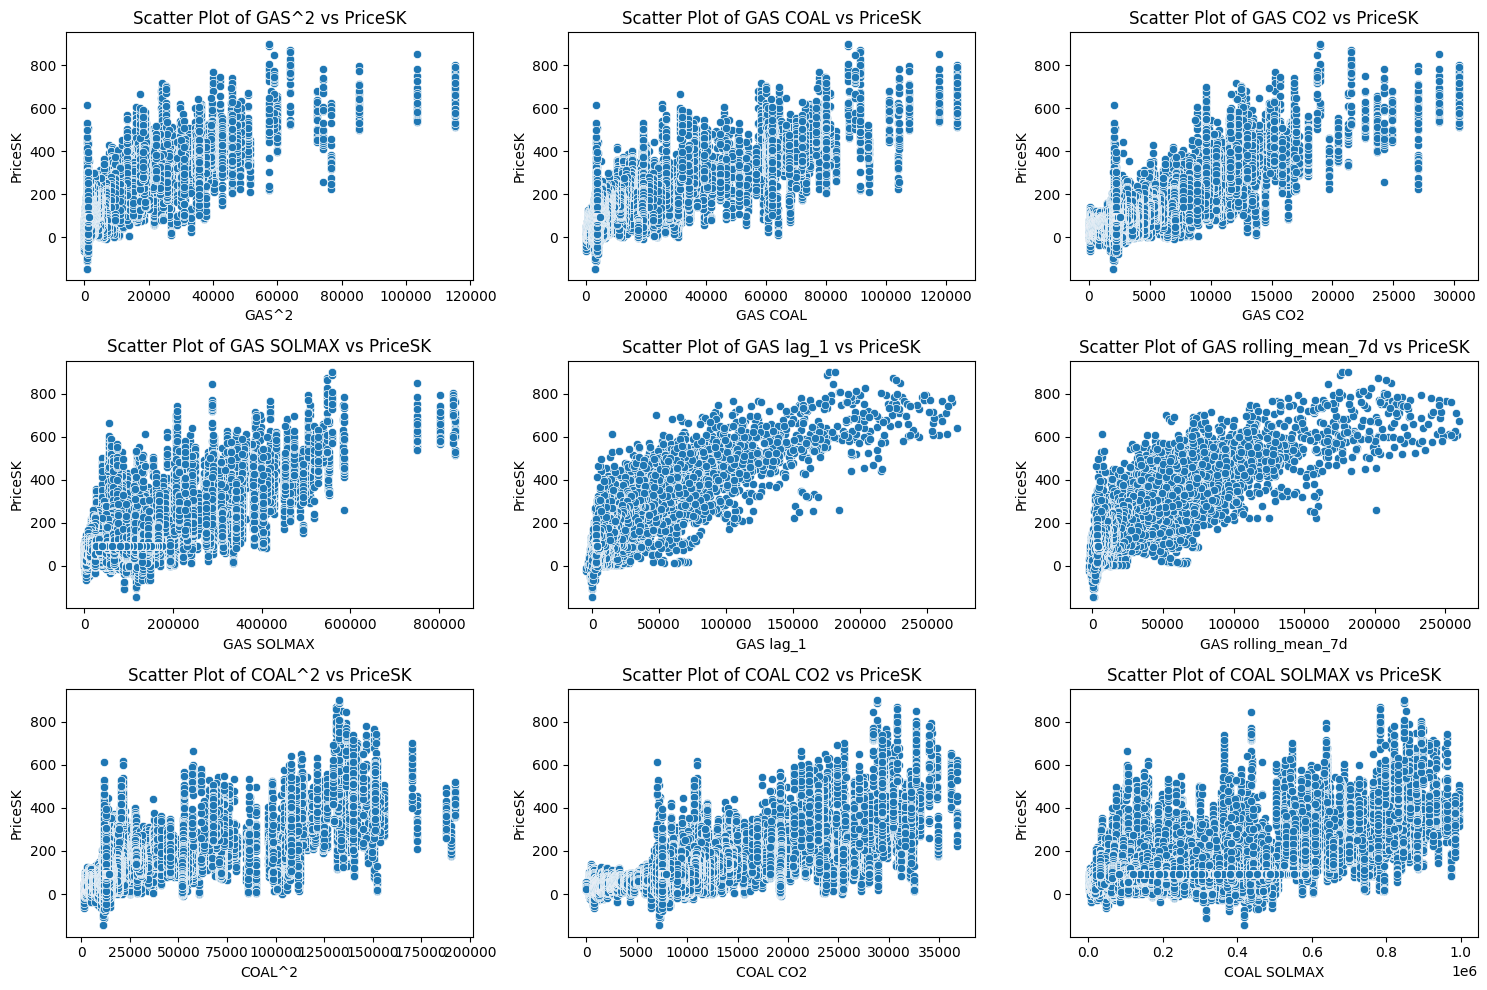

In [90]:
# Filter out valid polynomial feature names that are 1-dimensional
valid_features = [feature for feature in poly_feature_names if data[feature].ndim == 1]

# Plot some of the new polynomial features against the target variable
plt.figure(figsize=(15, 10))

for i, feature in enumerate(valid_features[:9], 1):  # Limiting to the first 9 features for a 3x3 grid
    plt.subplot(3, 3, i)
    sns.scatterplot(x=data[feature], y=data['PriceSK'])
    plt.title(f'Scatter Plot of {feature} vs PriceSK')

plt.tight_layout()
plt.show()

# Columns to Plot

In [63]:
# Define the column names to plot
column1 = 'UNAVTPPCZ'  # Replace with the actual column name
column2 = 'CO2'  # Replace with the actual column name
column3 = 'COALTOGAS'  # Replace with the actual column name
column4 = 'UNAVGASALL'  # Replace with the actual column name
column5 = 'SOLMAX'  # Replace with the actual column name
column6 = 'UNAVNUCFR'  # Replace with the actual column name

# date range plotting

In [64]:
# Define the date range for which you want to plot the data
start_date = '2018-01-01'  # Replace with the desired start date
end_date = '2018-02-01'  # Replace with the desired end date
start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)

In [65]:
# Filter data for the specific date range
data_range = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Handle missing values in PriceSK and other columns
data_range['PriceSK'] = data_range['PriceSK'].interpolate(method='linear')
data_range['PriceSK'] = data_range['PriceSK'].bfill().ffill()  # Use bfill() and ffill() directly


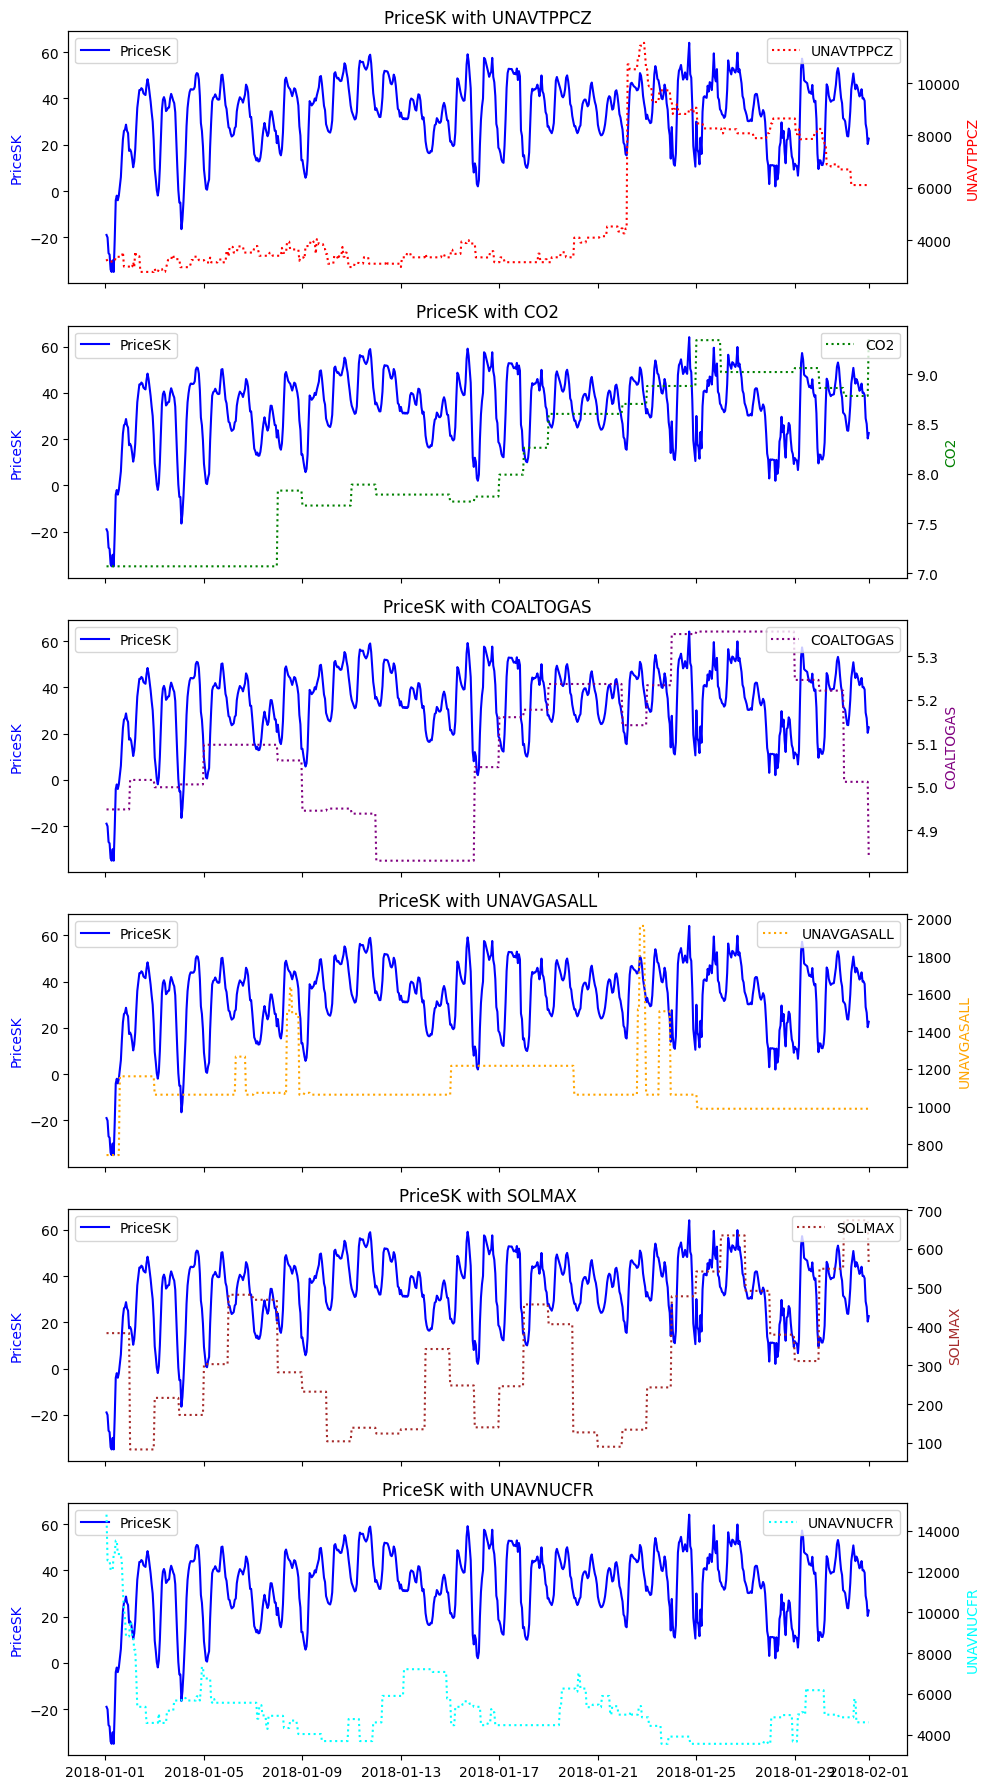

In [66]:
# Initialize a figure with subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 18), sharex=True)  # 6 separate subplots

# Plotting function to create subplots with secondary y-axes
def create_plot(ax, y1, y2, y1_label, y2_label, color1, color2):
    ax.plot(data_range['Date'], data_range[y1], label=y1_label, color=color1, linestyle='-')
    ax.set_ylabel(y1_label, color=color1)
    ax2 = ax.twinx()  # Create a secondary y-axis
    ax2.plot(data_range['Date'], data_range[y2], label=y2_label, color=color2, linestyle=':')
    ax2.set_ylabel(y2_label, color=color2)
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.set_title(f'{y1_label} with {y2_label}')

# Create plots for each subplot
create_plot(axes[0], 'PriceSK', column1, 'PriceSK', column1, 'blue', 'red')
create_plot(axes[1], 'PriceSK', column2, 'PriceSK', column2, 'blue', 'green')
create_plot(axes[2], 'PriceSK', column3, 'PriceSK', column3, 'blue', 'purple')
create_plot(axes[3], 'PriceSK', column4, 'PriceSK', column4, 'blue', 'orange')
create_plot(axes[4], 'PriceSK', column5, 'PriceSK', column5, 'blue', 'brown')
create_plot(axes[5], 'PriceSK', column6, 'PriceSK', column6, 'blue', 'cyan')

# Formatting and display
plt.xlabel('Date and Hour')
plt.tight_layout()
plt.show()

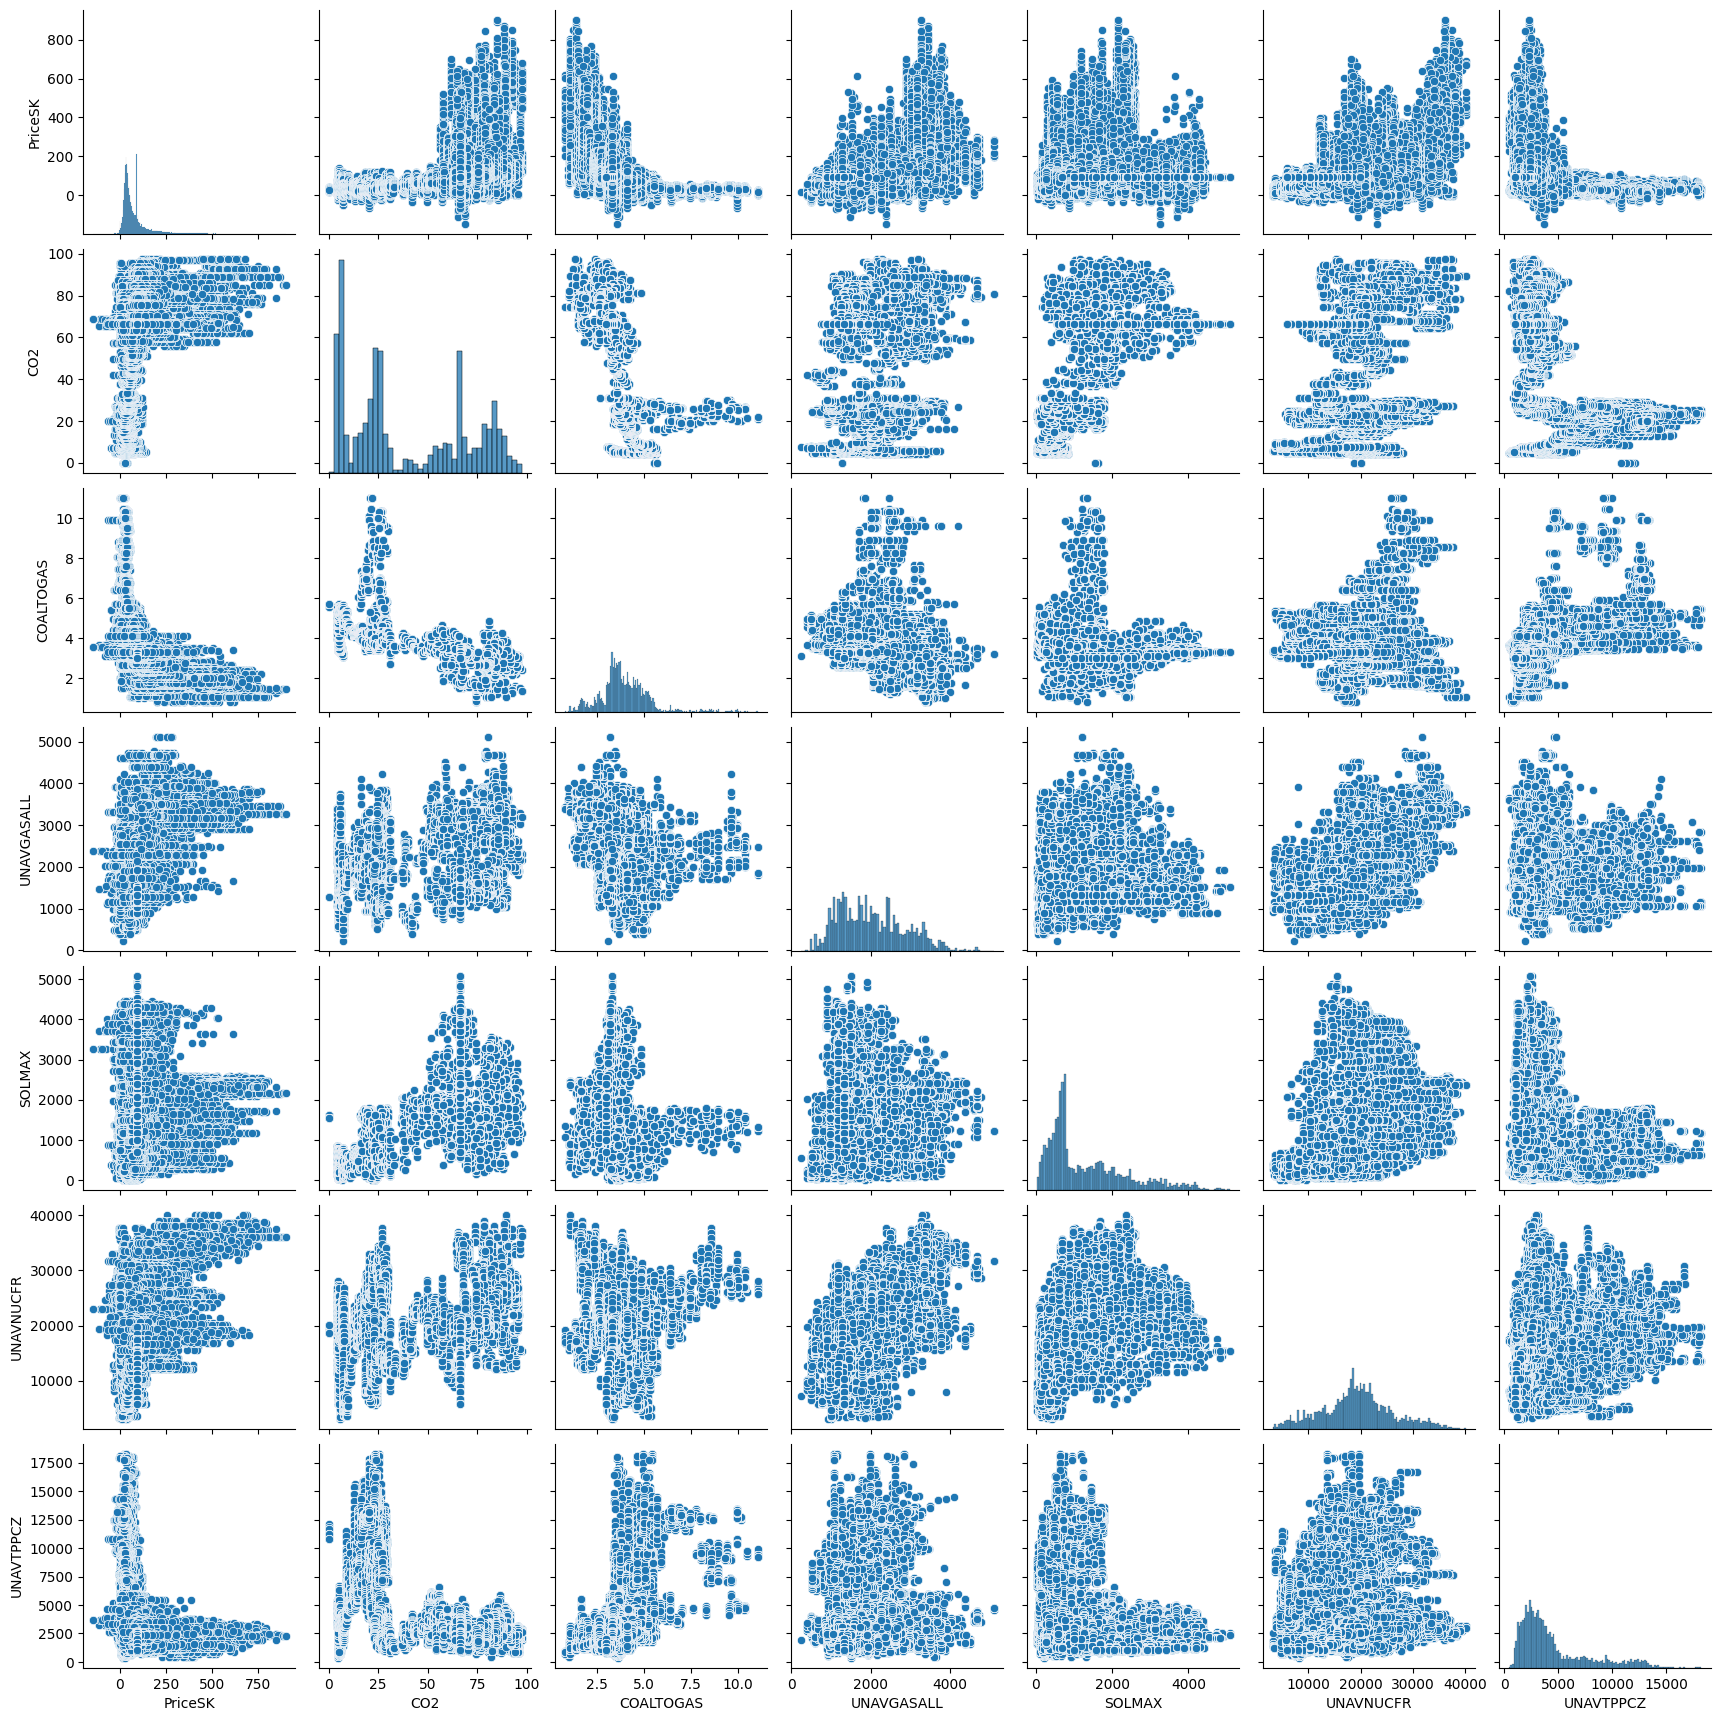

In [68]:
# Pairplot to visualize interactions
sns.pairplot(data[['PriceSK', 'CO2', 'COALTOGAS', 'UNAVGASALL', 'SOLMAX', 'UNAVNUCFR', 'UNAVTPPCZ']])
plt.show()